In [5]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

#import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
    #for filename in filenames:
        #print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [6]:

!pip install keract
import os
from glob import glob
import pandas as pd
import numpy as np
from numpy import expand_dims
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sn
from skimage.transform import resize
from skimage.color import gray2rgb
from sklearn.metrics import classification_report, confusion_matrix
from IPython.display import SVG
import keract
from tensorflow import keras
from tensorflow.keras import applications, optimizers
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.utils import to_categorical, model_to_dot, plot_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger, ReduceLROnPlateau

2021-09-19 02:53:35.816235: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


In [7]:
import os
from glob import glob
import pandas as pd
import numpy as np
from numpy import expand_dims
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sn
from skimage.transform import resize
from skimage.color import gray2rgb
from sklearn.metrics import classification_report, confusion_matrix
from IPython.display import SVG
import keract
from tensorflow import keras
from tensorflow.keras import applications, optimizers
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.utils import to_categorical, model_to_dot, plot_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger, ReduceLROnPlateau

In [8]:
data_dir = "../input/kermany2018/OCT2017 /"
train_data_dir= '../input/kermany2018/OCT2017 /train/'
val_data_dir= '../input/kermany2018/OCT2017 /val/'
test_data_dir= '../input/kermany2018/OCT2017 /test/'
img_width, img_height = 150, 150 
channels = 3
batch_size = 32
# image_arr_size= img_width * img_height * channels

In [9]:
train_datagen = ImageDataGenerator(
    rescale= 1./255,
    zoom_range= (0.73, 0.9),
    horizontal_flip= True,
    rotation_range= 10,
    width_shift_range= 0.10,
    fill_mode= 'constant',
    height_shift_range= 0.10,   
    brightness_range= (0.55, 0.9),
)

valid_test_datagen = ImageDataGenerator(
    rescale= 1./255, 
)

In [10]:
train_generator = train_datagen.flow_from_directory(  
    train_data_dir,  
    target_size= (img_width, img_height), 
    color_mode= 'rgb',
    batch_size= batch_size,  
    class_mode= 'categorical',
    shuffle= True, 
    seed= 1337
) 

valid_generator = valid_test_datagen.flow_from_directory(
    val_data_dir,
    target_size= (img_width, img_height),
    color_mode= 'rgb',
    batch_size= batch_size,  
    class_mode= 'categorical',
    shuffle= True, 
    seed= 1337
)

test_generator = valid_test_datagen.flow_from_directory(  
    test_data_dir,  
    target_size= (img_width, img_height), 
    color_mode= 'rgb',
    batch_size= batch_size,        
    class_mode= 'categorical',
    shuffle= False, 
)

Found 83484 images belonging to 4 classes.
Found 32 images belonging to 4 classes.
Found 968 images belonging to 4 classes.


In [11]:
num_classes = len(train_generator.class_indices)  
train_labels = train_generator.classes 
train_labels = to_categorical(train_labels, num_classes=num_classes)
valid_labels = valid_generator.classes 
valid_labels = to_categorical(valid_labels, num_classes=num_classes)
nb_train_samples = len(train_generator.filenames)  
nb_valid_samples = len(valid_generator.filenames)
nb_test_samples = len(test_generator.filenames)

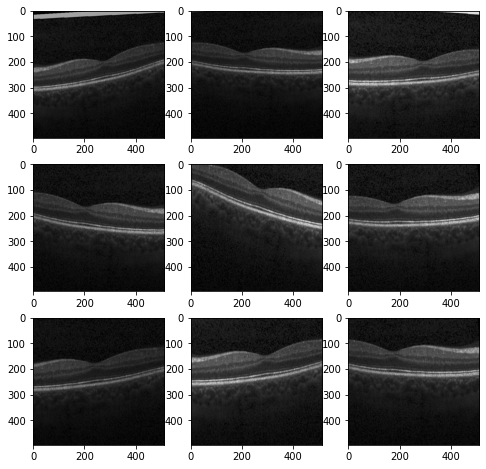

In [12]:
img = load_img('../input/kermany2018/OCT2017 /train/NORMAL/NORMAL-1001772-4.jpeg')
data = img_to_array(img)
samples = expand_dims(data, 0)
it = train_datagen.flow(samples, batch_size=1)
plt.rcParams['figure.figsize'] = (8.0, 8.0)

for i in range(9):
	plt.subplot(330 + 1 + i)
	batch = it.next()
	image = batch[0]
	plt.imshow(image)

plt.savefig('augmented_image.png', transparent= False, bbox_inches= 'tight', dpi= 400)
plt.show()

In [13]:
vgg16 = VGG16(include_top= False, input_shape= (img_width, img_height, channels), weights= 'imagenet')

2021-09-19 02:55:41.384794: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-09-19 02:55:41.388121: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-09-19 02:55:41.428399: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-09-19 02:55:41.429038: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla P100-PCIE-16GB computeCapability: 6.0
coreClock: 1.3285GHz coreCount: 56 deviceMemorySize: 15.90GiB deviceMemoryBandwidth: 681.88GiB/s
2021-09-19 02:55:41.429117: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2021-09-19 02:55:41.461118: I tensorflow/stream_executor/platform/def

58892288/58889256 [==============================] - 0s 0us/step


In [14]:
model = Sequential()

for layer in vgg16.layers:
    model.add(layer)

for layer in model.layers:
    layer.trainable= False

model.add(Flatten(input_shape= (4, 4, 512)))
model.add(Dropout(0.2))
model.add(Dense(4,activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 37, 37, 256)       2

In [15]:
model.compile(optimizer= keras.optimizers.Adam(lr= 0.0001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

In [16]:
checkpoint = ModelCheckpoint(
    'baseline_model.h5',
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    mode='auto',
    save_weights_only=False,
    period=1
)

earlystop = EarlyStopping(
    monitor='val_loss',
    min_delta=0.001,
    patience=3,
    verbose=1,
    mode='auto'
)

csvlogger = CSVLogger(
    filename= "baseline_training_csv.log",
    separator = ",",
    append = False
)

reduceLR = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=3,
    verbose=1, 
    mode='auto'
)

In [17]:
callbacks = [checkpoint, earlystop, csvlogger,reduceLR]

In [18]:

history = model.fit(
    train_generator, 
    epochs = 30,
    steps_per_epoch = nb_train_samples//batch_size,
    validation_data = valid_generator, 
    validation_steps = nb_valid_samples//batch_size,
    verbose = 2,
    callbacks = callbacks,
    shuffle = True
)

2021-09-19 02:55:44.936947: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-09-19 02:55:44.940793: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2000175000 Hz


Epoch 1/30


2021-09-19 02:55:45.527264: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2021-09-19 02:55:46.344949: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11
2021-09-19 02:55:46.379203: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.8


2608/2608 - 1295s - loss: 0.6680 - accuracy: 0.7568 - val_loss: 0.5031 - val_accuracy: 0.7500

Epoch 00001: val_loss improved from inf to 0.50311, saving model to baseline_model.h5
Epoch 2/30
2608/2608 - 817s - loss: 0.5061 - accuracy: 0.8176 - val_loss: 0.4140 - val_accuracy: 0.8438

Epoch 00002: val_loss improved from 0.50311 to 0.41398, saving model to baseline_model.h5
Epoch 3/30
2608/2608 - 827s - loss: 0.4714 - accuracy: 0.8312 - val_loss: 0.3646 - val_accuracy: 0.8750

Epoch 00003: val_loss improved from 0.41398 to 0.36457, saving model to baseline_model.h5
Epoch 4/30
2608/2608 - 805s - loss: 0.4497 - accuracy: 0.8369 - val_loss: 0.3833 - val_accuracy: 0.9375

Epoch 00004: val_loss did not improve from 0.36457
Epoch 5/30
2608/2608 - 789s - loss: 0.4376 - accuracy: 0.8426 - val_loss: 0.3593 - val_accuracy: 0.8438

Epoch 00005: val_loss improved from 0.36457 to 0.35935, saving model to baseline_model.h5
Epoch 6/30
2608/2608 - 772s - loss: 0.4302 - accuracy: 0.8444 - val_loss: 0.35

In [19]:

(eval_loss, eval_accuracy) = model.evaluate(test_generator, batch_size= batch_size, verbose= 1)
print('Test Loss: ', eval_loss)
print('Test Accuracy: ', eval_accuracy)

31/31 [==============================] - 10s 336ms/step - loss: 0.3666 - accuracy: 0.8595
Test Loss:  0.3665916323661804
Test Accuracy:  0.8595041036605835


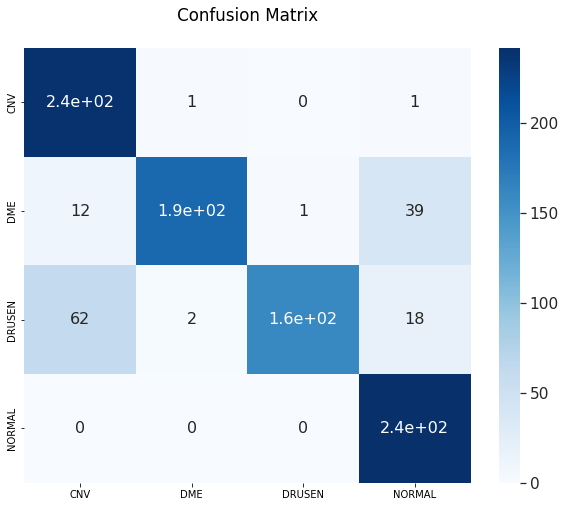

Classification Report

              precision    recall  f1-score   support

         CNV       0.76      0.99      0.86       242
         DME       0.98      0.79      0.87       242
      DRUSEN       0.99      0.66      0.79       242
      NORMAL       0.81      1.00      0.89       242

    accuracy                           0.86       968
   macro avg       0.89      0.86      0.86       968
weighted avg       0.89      0.86      0.86       968



In [20]:
Y_pred = model.predict(test_generator, nb_test_samples // batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)
cm = confusion_matrix(test_generator.classes, y_pred)
df_cm = pd.DataFrame(cm, list(test_generator.class_indices.keys()), list(test_generator.class_indices.keys()))
fig, ax = plt.subplots(figsize=(10,8))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}, cmap=plt.cm.Blues)
plt.title('Confusion Matrix\n')
plt.savefig('confusion_matrix.png', transparent= False, bbox_inches= 'tight', dpi= 400)
plt.show()

print('Classification Report\n')
target_names = list(test_generator.class_indices.keys())
print(classification_report(test_generator.classes, y_pred, target_names=target_names))